케글에서 다운받은 데이터 :

[WA_Fn-UseC_-Telco-Customer-Churn.csv](https://www.kaggle.com/blastchar/telco-customer-churn?select=WA_Fn-UseC_-Telco-Customer-Churn.csv)

# 시나리오

이번에 다뤄볼 주제는 한 통신사의 고객 이탈에 관한 것입니다. 통신사 A의 고질병은 바로 줄어들지않는 고객 이탈률입니다. 이 통신사는 고객 이탈을 방지하기위해 고객들이 다음 계약을 할 때 사은품을 증정하기로 계획했습니다. 하지만, 사은품을 고객 모두에게 주는 것은 통신사에게도 큰 부담이니 최대한 이탈할것같은 고객들에게 사은품을 증정해 고객 이탈을 막고싶어합니다.

* 고려해야 할 점 : "사은품의 가격" vs "고객이 이탈에 의한 손실"

이 시나리오에선, 사은품을 증정하는것이 효과적으로 고객 이탈을 막을 수 있고, 사은품의 가격보다 고객을 유지하는 것이 회사에게 더 이득이라고 가정하겠습니다.

이것은 Recall 과 직결되는데요, Recall 값을 올리면 FP(이탈하지 않을 고객을 이탈한다고 예측) 이 증가하지만 그 고객들에게 사은품을 주는것은 그렇게 큰 손실이 아닙니다. 반대로 Precision 값을 올리면 FN (이탈할 고객을 이탈하지 않는다고 예측) 이 증가하는데, 이것은 고객 이탈을 방지하지 못하기때문에 회사에게 손실이 큽니다. 즉, 이 문제에선 recall 값을 좀 더 중요하게 봐야합니다.

In [ ]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [ ]:
# 라이브러리 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
import eli5
from eli5.sklearn import PermutationImportance
from scipy.stats import randint, uniform
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import xgboost
import shap

In [ ]:
# 파일 업로드
from google.colab import files
uploaded = files.upload()

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn (1).csv


In [ ]:
# 파일 불러오기
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


타겟 설명 :

Churn : 이탈 여부 (Yes, No)

---

피쳐설명 : 

customerID : Customer ID

gender : 남자 or 여자 (Male, Female)

SeniorCitizen : 고령인지, 아닌지 (1, 0)

Partner : 배우자 여부 (1, 0)

Dependents : 부양할 가족이 여부 (1, 0)

tenure : 서비스 이용 기간 (월)

PhoneService : 폰 서비스 여부 (1, 0)

MultipleLines : 여러개 라인을 쓰는지 (Yes, No, No phone service)

InternetService : 인터넷 서비스 공급 (DSL, Fiber optic, No)

OnlineSecurity : 온라인 보안 여부 (Yes, No, No internet service)

OnlineBackup : 온라인 백업 여부 (Yes, No, No internet service)

DeviceProtection : 기기 보험 여부 (Yes, No, No internet service)

TechSupport : 기술 지원을 받는지 여부 (Yes, No, No internet service)

StreamingTV : 스트리밍 TV 서비스 사용 여부 (Yes, No, No internet service)

StreamingMovies : 스트리밍 영화 서비스 사용 여부 (Yes, No, No internet service)

Contract : 계약 기간 조건 (Month-to-month, One year, Two year)

PaperlessBilling : paperless 청구서를 받는지 (Yes, No)

PaymentMethod : 지불 방식 (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))

MonthlyCharges : 한달 사용료

TotalCharges : 전체 사용료

# Part 1: 데이터 전처리 (Data Preprocessing) 시작!

In [ ]:
# 데이터 shape, 타입 확인
print(df.shape)
print("---------------------------")
df.dtypes

(7043, 21)
---------------------------


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

여기서, TotalCharges 가 숫자형으로 보이지않고 Object 형태로 되어있는걸 보실 수 있습니다. 숫자형태로 바꿔주겠습니다.

In [ ]:
# TotalCharges 가 숫자형태여야 한다는걸 확인
df.TotalCharges.values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [ ]:
# TotalCharges 숫자형으로 변환
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')

In [ ]:
# 결측치 확인
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [ ]:
# 결측치 드랍
df = df.dropna()

In [ ]:
# customerID 드랍
df = df.drop(columns='customerID')

In [ ]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


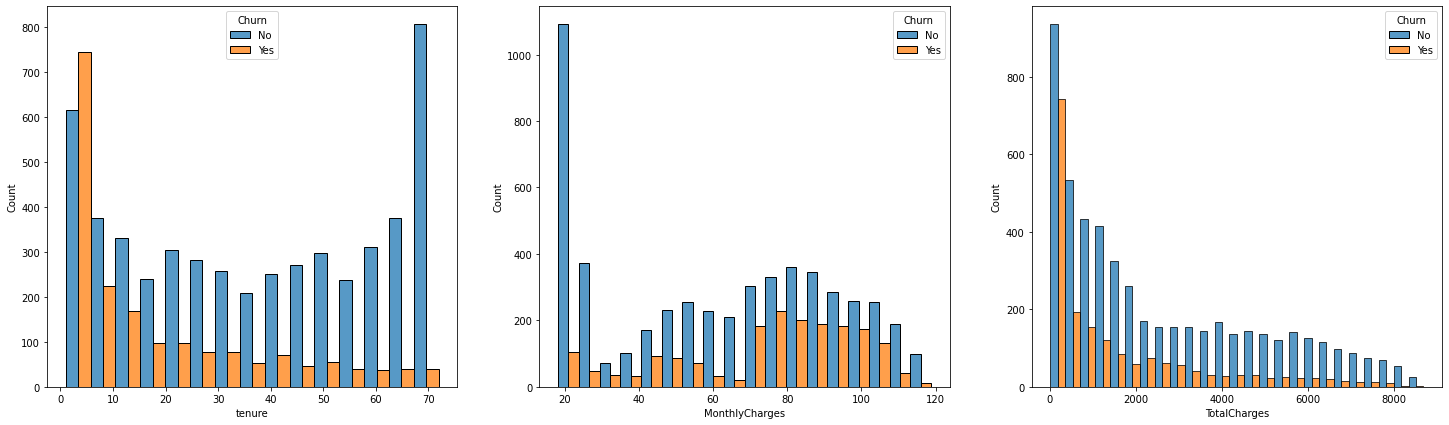

In [ ]:
# 숫자형 피쳐들 시각화
plt.figure(figsize=(25,7))
plt.subplot(1,3,1)
sns.histplot(df, x="tenure", hue="Churn", multiple="dodge")
plt.subplot(1,3,2)
sns.histplot(df, x="MonthlyCharges", hue="Churn", multiple="dodge")
plt.subplot(1,3,3)
sns.histplot(df, x="TotalCharges", hue="Churn", multiple="dodge")

1. tenure(서비스 이용 기간(월))이 짧은 고객들의 이탈률이 높고, 오래 이용한 고객들은 이탈률이 낮습니다.

2. MonthlyCharges (한달 사용료)가 70 쯤일때 이탈률이 급격히 높아졌다가 점차 줄어듭니다. (60달러보다 70달러를 내는 서비스의 가성비가 갑자기 안좋아진건지 의심스럽네요!)

3. TotalCharges (전체 사용료)가 낮은 고객들의 이탈이 가장 많은데, 이것은 아마 1번에서 말한 "서비스 이용 기간"과 연관이 있는것같습니다. ("서비스 이용 기간"이 짧은 고객들은 자연스럽게 "전체 사용료" 가 낮으니 그런듯 싶습니다)

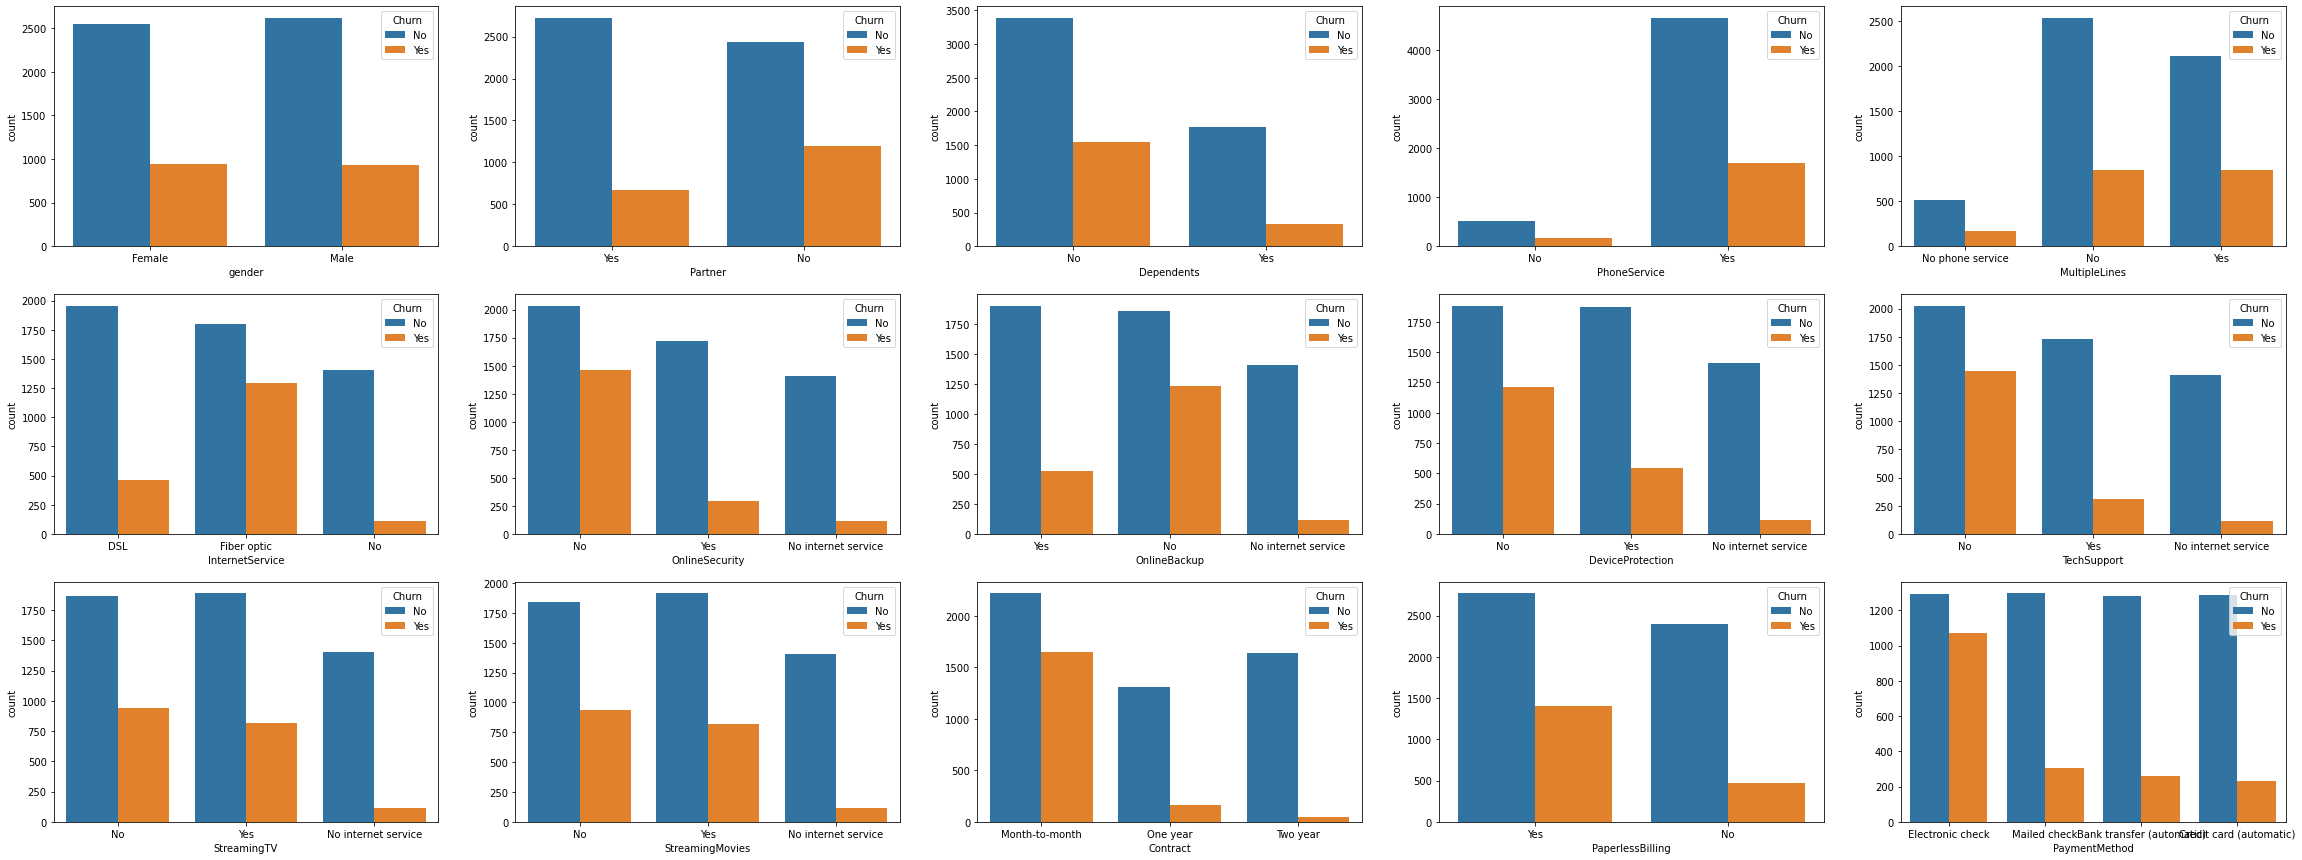

In [ ]:
# 어떻게 인코딩 해야하나 확인하기위해 범주형 피쳐들과 타겟의 관계를 시각화해보기
plt.figure(figsize=[40,15])
plt.subplot(3,5,1)
sns.countplot(df['gender'], hue=df['Churn'])
plt.subplot(3,5,2)
sns.countplot(df['Partner'], hue=df['Churn'])
plt.subplot(3,5,3)
sns.countplot(df['Dependents'], hue=df['Churn'])
plt.subplot(3,5,4)
sns.countplot(df['PhoneService'], hue=df['Churn'])
plt.subplot(3,5,5)
sns.countplot(df['MultipleLines'], hue=df['Churn'])
plt.subplot(3,5,6)
sns.countplot(df['InternetService'], hue=df['Churn'])
plt.subplot(3,5,7)
sns.countplot(df['OnlineSecurity'], hue=df['Churn'])
plt.subplot(3,5,8)
sns.countplot(df['OnlineBackup'], hue=df['Churn'])
plt.subplot(3,5,9)
sns.countplot(df['DeviceProtection'], hue=df['Churn'])
plt.subplot(3,5,10)
sns.countplot(df['TechSupport'], hue=df['Churn'])
plt.subplot(3,5,11)
sns.countplot(df['StreamingTV'], hue=df['Churn'])
plt.subplot(3,5,12)
sns.countplot(df['StreamingMovies'], hue=df['Churn'])
plt.subplot(3,5,13)
sns.countplot(df['Contract'], hue=df['Churn'])
plt.subplot(3,5,14)
sns.countplot(df['PaperlessBilling'], hue=df['Churn'])
plt.subplot(3,5,15)
sns.countplot(df['PaymentMethod'], hue=df['Churn'])

대부분 연속적인 숫자로 바꾸면 그대로 의미가 있을것같다. 하지만, Ordinal 인코딩을 할 경우 특정 순서대로 의미가 있는 범주형 변수들이 올바른 순서대로 숫자를 배정받지않고 섞일수도 있다고 생각해서 직접 넣어주겠습니다. (예를들어 이런 상황을 방지하기위해 (low, mid high -> 2,0,1))

but!!! 이후에 원 핫 인코딩이 더 좋은 성능을 보여줘서 아래의 코드를 사용하지는 않았습니다. 그래도 이런 시험을 해봤기에 남겨 놓으려고 합니다 ㅎㅎ.


In [ ]:
# # 아래 과정은 ordinal 대신 직접 순서대로 숫자를 넣어주는 것입니다. 하지만 원핫인코딩이 더 좋은 결과를 보여서 생략했습니다.

# # 숫자형으로 바꿔주기 
# df['Partner'] = df['Partner'].apply(lambda x: 1 if x in ['Yes'] else 0)
# df['Dependents'] = df['Dependents'].apply(lambda x: 1 if x in ['Yes'] else 0)
# df['PhoneService'] = df['PhoneService'].apply(lambda x: 1 if x in ['Yes'] else 0)

# def enc_MultipleLines(x):
#     if x in ['Yes']: return 2
#     elif x in ['No']: return 1
#     else: return 0

# df['MultipleLines'] = df['MultipleLines'].apply(enc_MultipleLines)

# def enc_InternetService(x):
#     if x in ['Fiber optic']: return 2
#     elif x in ['DSL']: return 1
#     else: return 0

# df['InternetService'] = df['InternetService'].apply(enc_InternetService)

# def yes_no_nis(x):
#     if x in ['No internet service']: return 2
#     elif x in ['Yes']: return 1
#     else: return 0

# df['OnlineSecurity'] = df['OnlineSecurity'].apply(yes_no_nis)
# df['OnlineBackup'] = df['OnlineBackup'].apply(yes_no_nis)
# df['DeviceProtection'] = df['DeviceProtection'].apply(yes_no_nis)
# df['TechSupport'] = df['TechSupport'].apply(yes_no_nis)
# df['StreamingTV'] = df['StreamingTV'].apply(yes_no_nis)
# df['StreamingMovies'] = df['StreamingMovies'].apply(yes_no_nis)

# def enc_Contract(x):
#     if x in ['Month-to-month']: return 2
#     elif x in ['One year']: return 1
#     else: return 0

# df['Contract'] = df['Contract'].apply(enc_Contract)

# df['PaperlessBilling'] = df['PaperlessBilling'].apply(lambda x: 1 if x in ['Yes'] else 0)

# df['PaymentMethod'] = df['PaymentMethod'].apply(lambda x: 1 if x in ['Electronic check'] else 0)

In [ ]:
# 타겟을 숫자로
df['Churn'] = df['Churn'].apply(lambda x: 1 if x in ['Yes'] else 0)

In [ ]:
# 성별은 큰 영향이 없으니 삭제 
df = df.drop(columns='gender')

피쳐는 여러개를 새로 만들어봤지만 대부분 Permutation Importance 에서 낮은 값을 나타내서 한가지만 남겨놓았습니다. 위의 숫자형 데이터들은 특정 범위에서 높은 이탈률을 보였습니다. 그 중 이용 기간과 월 이용료를 이용해서 한가지 피쳐를 만들어 보았습니다. 이용기간은 6개월 이하가 이탈률이 가장높고, 월 이용료는 70~100 정도 사이가 가장 높으니 그 두 가지 모두에 해당하는 피쳐를 만들었습니다.

In [ ]:
# 이용한지 6개월 이하인데 비싼 요금을 내고있는 이용자들 피쳐 만들기
df['NewBigSpender'] = (df.MonthlyCharges >= 70) & (df.MonthlyCharges <= 100) & (df.tenure <= 6)

In [ ]:
# 새로운 피쳐 Yes No 로 바꿔주기 (원핫인코딩 되게하려고)
df['NewBigSpender'] = df['NewBigSpender'].apply(lambda x: 'Yes' if x in [True] else 'No')

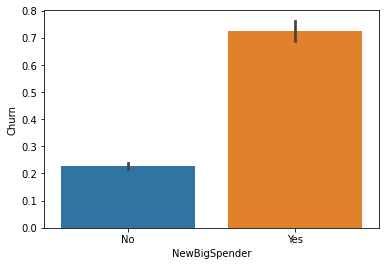

In [ ]:
# 새로만든 피쳐와 타겟의 시각화
sns.barplot('NewBigSpender','Churn',data=df)

서비스를 이용한지 6개월 이하인 고객중 비싼 요금을 내는 고객들은 이탈률이 매우 높다.

In [ ]:
# 나머지는 원핫인코딩 (원래는 순서형으로 했지만 원핫인코딩이 더 성능이 좋게나와서 원핫인코딩을 쓰겠습니다)
print(df.shape)
df.head()

(7032, 20)


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NewBigSpender
0,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,No
1,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,No
2,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,No
3,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,No
4,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,Yes


In [ ]:
## 원핫 인코딩
encoder = OneHotEncoder(use_cat_names = True)
df = encoder.fit_transform(df)

In [ ]:
# 인코딩 후
df.shape

(7032, 46)

In [ ]:
# 타겟과 피쳐들의 상관관계
df.apply(lambda x : pd.factorize(x)[0]).corr().sort_values(by='Churn', ascending=False)['Churn']

Churn                                      1.000000
InternetService_Fiber optic                0.307463
NewBigSpender_Yes                          0.299898
NewBigSpender_No                           0.299898
OnlineBackup_No                            0.267595
SeniorCitizen                              0.150541
Partner_Yes                                0.149982
Partner_No                                 0.149982
InternetService_DSL                        0.124141
OnlineBackup_Yes                           0.082307
StreamingTV_Yes                            0.063254
StreamingMovies_Yes                        0.060860
MultipleLines_Yes                          0.040033
MonthlyCharges                             0.020303
PhoneService_No                            0.011691
MultipleLines_No phone service             0.011691
PhoneService_Yes                           0.011691
TotalCharges                              -0.028994
MultipleLines_No                          -0.032654
DeviceProtec

leakage는 없어보입니다.

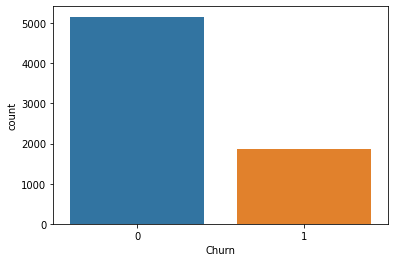

In [ ]:
# 타겟의 분포 
sns.countplot(df['Churn'])

이진 분류문제에서 타겟이 불균형할때는 accracy 보다 f1 스코어가 더 좋은 평가지표이니 f1 스코어를 중점적으로 보겠습니다.

## 전처리 끝!

# 모델 성능 비교


### 1. LogisticRegression

### 2. Decision Tree

### 3. Random Forest

### 4. XGBoosting


In [ ]:
# 훈련, 테스트 셋을 나누기
train, test = train_test_split(df, test_size=1000, random_state=3)
train.shape, test.shape

((6032, 46), (1000, 46))

In [ ]:
# 훈련, 검증 셋을 나누기
train, val = train_test_split(train, test_size=1000, random_state=3)
train.shape, val.shape, test.shape

((5032, 46), (1000, 46), (1000, 46))

In [ ]:
# 타겟과 피쳐 나누기
target = 'Churn'
features = df.drop(columns=[target]).columns

X_train = train[features]
X_val = val[features]
X_test = test[features]

y_train = train[target]
y_val = val[target]
y_test = test[target]

In [ ]:
# Logistic, DecisionTree, RandomForest, XGB 비교 (F1-score)
classifiers = [LogisticRegression(random_state=1), 
               DecisionTreeClassifier(random_state=1), 
               RandomForestClassifier(random_state=1), 
               XGBClassifier(random_state=1)
               ]
for cls in classifiers:
    cls.fit(X_train, y_train)
    y_pred_train = cls.predict(X_train)
    y_pred_val = cls.predict(X_val)
    print("-----------------------", cls)
    print("훈련 f1 : ", f1_score(y_pred_train, y_train))
    print("검증 f1 : ", f1_score(y_pred_val, y_val))
    

----------------------- LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
훈련 f1 :  0.5978441127694859
검증 f1 :  0.6101694915254238
----------------------- DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')
훈련 f1 :  0.9950924877312194
검증 f1 :  0.509532062391681
----------------------- RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=Non

DT가 비교적 성능이 안좋고, DT와 RF는 과적합되어있다고 볼 수 있습니다. 하지만 이후 하이퍼파라미터 튜닝을 통해 과적합을 어느정도 잡아줄 수 있습니다. 

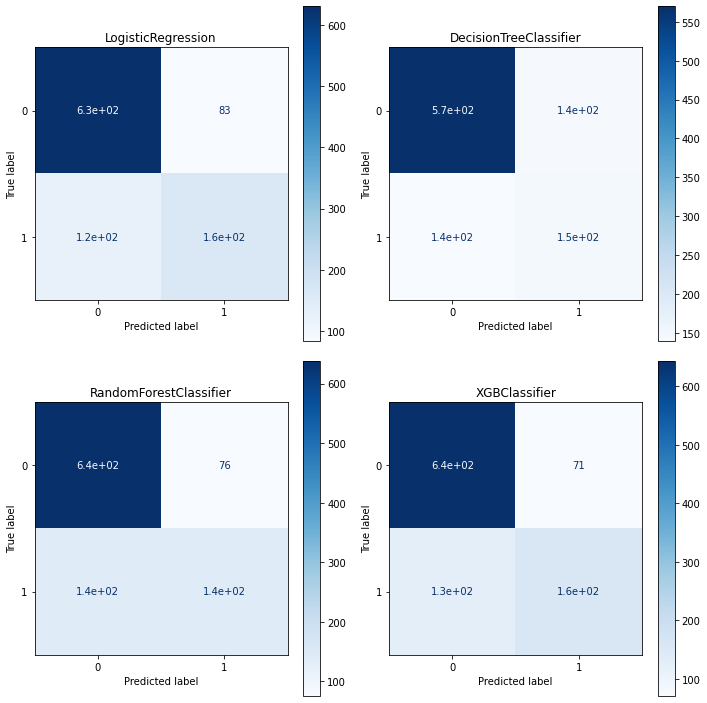

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_val, 
                          y_val, 
                          ax=ax, 
                          cmap='Blues',
                         display_labels=val[target])
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

비교적 잘맞춘 LogisticRegression, RandomForestClassifier, XGBClassifier 를 중점적으로 하이퍼 파라미터를 튜닝해서 다시 비교해보겠습니다. 

# 하이퍼 파라미터 튜닝

### Logistic Regression

1. C (Inverse of regularization strength)

2. class_weight (불균형 클래스인 경우)

3. penalty

### Random Forest

1. class_weight (imbalanced 클래스인 경우)

2. max_depth (높은값에서 감소시키며 튜닝, 너무 깊어지면 과적합)

3. n_estimators (적을경우 과소적합, 높을경우 긴 학습시간)

4. min_samples_leaf (과적합일경우 높임)

5. max_features (줄일 수록 다양한 트리생성, 높이면 같은 특성을 사용하는 트리가 많아져 다양성이 감소)

### XGBoost

1. scale_pos_weight (imbalanced 클래스인 경우)

2. max_depth (낮은값에서 증가시키며 튜닝, 너무 깊어지면 과적합)

3. n_estimators (작을경우 과소적합, 높을경우 긴 학습시간) - Early Stopping 사용!

4. learning_rate (작을경우 과소적합, 높을경우 과적합)

# Logistic Regression

In [ ]:
# RandomizedSearchCV 를 이용해서 Logistic Regression 모델 최적의 하이퍼파라미터 찾기

lg_pipe = make_pipeline(
    # 인코딩과 결측치처리는 이전에 해서 생략
    # SimpleImputer(), 
    # OneHotEncoder(use_cat_names=True),
    LogisticRegression(random_state=1)
)
# C (Inverse of regularization strength)
# class_weight (불균형 클래스인 경우)
# penalty

lg_dists = {
    'logisticregression__C': [0.1, 0.3, 0.5, 0.7, 0.9],
    'logisticregression__class_weight': [None, 'balanced'], 
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet', 'none']

}

lg_clf = RandomizedSearchCV(
    lg_pipe, 
    param_distributions=lg_dists, 
    n_iter=50, 
    cv=5, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1,
    random_state=1
)

lg_clf.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 197 out of 200 | elapsed:   13.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   13.7s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logisticregression',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=100,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l2',
                                  

In [ ]:
print('CV F1-score: ', lg_clf.best_score_)

CV F1-score:  0.6325945194340112


### Logistic 모델로 검증셋 예측 후 F1, AUC 스코어 보기

In [ ]:
# logistic 모델로 검증셋 f1 스코어 보기

# 최적의 파라미터로 다시 학습
lg = lg_clf.best_estimator_
lg.fit(X_train, y_train)

y_pred_lg = lg.predict(X_val)
print('검증 f1_score: ', f1_score(y_val, y_pred_lg))
print("======================================================")
print(classification_report(y_pred_lg, y_val))

검증 f1_score:  0.6286509040333798
              precision    recall  f1-score   support

           0       0.71      0.89      0.79       567
           1       0.79      0.52      0.63       433

    accuracy                           0.73      1000
   macro avg       0.75      0.71      0.71      1000
weighted avg       0.74      0.73      0.72      1000



In [ ]:
# 검증셋의 AUC 스코어
lg_auc_score = roc_auc_score(y_val, lg.predict_proba(X_val)[:,1])
print('AUC 스코어 : ', lg_auc_score)

AUC 스코어 :  0.8408209437621204


# Random Forest

In [ ]:
# RandomizedSearchCV 를 이용해서 Random Forest 모델 최적의 하이퍼파라미터 찾기

rf_pipe = make_pipeline(
    # 인코딩과 결측치처리는 이전에 해서 생략
    # SimpleImputer(), 
    # OneHotEncoder(use_cat_names=True), 
    RandomForestClassifier(n_estimators=100,random_state=1,n_jobs=-1)
)
# class_weight (imbalanced 클래스인 경우)
# max_depth (높은값에서 감소시키며 튜닝, 너무 깊어지면 과적합)
# n_estimators (적을경우 과소적합, 높을경우 긴 학습시간)
# min_samples_leaf (과적합일경우 높임)
# max_features (줄일 수록 다양한 트리생성, 높이면 같은 특성을 사용하는 트리가 많아져 다양성이 감소)

rf_dists = {
    'randomforestclassifier__class_weight': [None, 'balanced'],
    'randomforestclassifier__max_depth': [3, 5, 7, 9, 11, 13, 15], 
    'randomforestclassifier__min_samples_leaf': [5,10,20,30,40,50,60],
    'randomforestclassifier__max_features': [0.1, 0.3, 0.5, 0.7, 1],

}

rf_clf = RandomizedSearchCV(
    rf_pipe, 
    param_distributions=rf_dists, 
    n_iter=50, 
    cv=5, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1,
    random_state=1
)

rf_clf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('randomforestclassifier',
                                              RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                                     max_leaf_nodes=None,
                                                                     max_samples=None,
                                                                     min_impurity_decrease=0.0,
                                           

In [ ]:
print('CV F1-score: ', rf_clf.best_score_)

CV F1-score:  0.6322582051906407


### random forest 모델로 검증셋 예측 후 F1, AUC 스코어 보기

In [ ]:
# random forest 모델로 검증셋 f1 스코어 보기

# 최적의 파라미터로 다시 학습
rf = rf_clf.best_estimator_
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)
print('검증 f1_score: ', f1_score(y_val, y_pred_rf))
print("======================================================")
print(classification_report(y_pred_rf, y_val))

검증 f1_score:  0.648876404494382
              precision    recall  f1-score   support

           0       0.73      0.90      0.81       574
           1       0.81      0.54      0.65       426

    accuracy                           0.75      1000
   macro avg       0.77      0.72      0.73      1000
weighted avg       0.76      0.75      0.74      1000



In [ ]:
# 검증셋의 AUC 스코어
rf_auc_score = roc_auc_score(y_val, rf.predict_proba(X_val)[:,1])
print('AUC 스코어 : ', rf_auc_score)

AUC 스코어 :  0.84502997002997


# XGBoost

In [ ]:
# RandomizedSearchCV 를 이용해서 XGB 모델 최적의 하이퍼파라미터 찾기

xgb_pipe = make_pipeline(
    # 인코딩과 결측치처리는 이전에 해서 생략
    # SimpleImputer(), 
    # OneHotEncoder(use_cat_names=True), 
    XGBClassifier(n_estimators=100,random_state=1,n_jobs=-1)
)
# scale_pos_weight (imbalanced 클래스인 경우)
# max_depth (낮은값에서 증가시키며 튜닝, 너무 깊어지면 과적합)
# n_estimators (작을경우 과소적합, 높을경우 긴 학습시간) - Early Stopping 사용!
# learning_rate (작을경우 과소적합, 높을경우 과적합)

xgb_dists = {
    'xgbclassifier__monotone_constraints':'(-1,0,1)', 
    'xgbclassifier__scale_pos_weight': [0.265, 0.50, 0.735, 1],
    'xgbclassifier__max_depth': [3, 5, 7, 9, 11, 13, 15], 
    'xgbclassifier__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
}

xgb_clf = RandomizedSearchCV(
    xgb_pipe, 
    param_distributions=xgb_dists, 
    n_iter=50, 
    cv=5, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1,
    random_state=1
)

xgb_clf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('xgbclassifier',
                                              XGBClassifier(base_score=0.5,
                                                            booster='gbtree',
                                                            colsample_bylevel=1,
                                                            colsample_bynode=1,
                                                            colsample_bytree=1,
                                                            gamma=0,
                                                            learning_rate=0.1,
                                                            max_delta_step=0,
                                                            max_depth=3,
                                                            min_child_weight=1,
                                                            missing=No

In [ ]:
print('CV F1-score: ', xgb_clf.best_score_)

CV F1-score:  0.5762168184037201


### XGBoost 모델로 검증셋 예측 후 F1, AUC 스코어 보기

In [ ]:
# xgboost 모델로 검증셋 f1 스코어 보기

# 최적의 파라미터로 다시 학습
xgb = xgb_clf.best_estimator_
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_val)
print('검증 f1_score: ', f1_score(y_val, y_pred_xgb))
print("======================================================")
print(classification_report(y_pred_xgb, y_val))

검증 f1_score:  0.5938697318007664
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       764
           1       0.54      0.66      0.59       236

    accuracy                           0.79      1000
   macro avg       0.71      0.74      0.73      1000
weighted avg       0.81      0.79      0.79      1000



In [ ]:
# 검증셋의 AUC 스코어
xgb_auc_score = roc_auc_score(y_val, xgb.predict_proba(X_val)[:,1])
print('AUC 스코어 : ', xgb_auc_score)

AUC 스코어 :  0.8348538716185775


## 세 모델 비교 

LogisticRegression

* 검증셋 F1 = 0.628

* 검증셋 AUC = 0.840

RandomForestClassifier

* 검증셋 F1 = 0.649

* 검증셋 AUC = 0.845

XGBclassifier

* 검증셋 F1 = 0.593

* 검증셋 AUC = 0.834


### => RandomForestClassifier 가 F1, AUC 스코어 모두에서 다른 모델들보다 점수가 높으니 선택하겠습니다!

## Random Forest 를 쓰기로 결정!

# Permutation importance 을 이용해 모델 성능에 중요한 특성들만 선택

In [ ]:
# Permutation inportance

# permuter for logistic regression
permuter = PermutationImportance(
    rf.named_steps['randomforestclassifier'], 
    scoring='f1', 
    n_iter=10, 
    random_state=1
)

permuter.fit(X_val, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight='balanced',
                                                       criterion='gini',
                                                       max_depth=7,
                                                       max_features=0.3,
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=10,
                                                       min_samples_split=2,
                                                       min_weight_f

In [ ]:
# 특성별 score 확인
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0610 ± 0.0248,Contract_Month-to-month
0.0211 ± 0.0180,tenure
0.0149 ± 0.0090,TotalCharges
0.0050 ± 0.0199,InternetService_Fiber optic
0.0029 ± 0.0097,PaymentMethod_Electronic check
0.0029 ± 0.0023,PaymentMethod_Mailed check
0.0010 ± 0.0023,DeviceProtection_Yes
0.0006 ± 0.0024,NewBigSpender_No
0.0005 ± 0.0023,InternetService_No
0.0003 ± 0.0008,NewBigSpender_Yes


위의 Permutation importance 를 보니 0 이하의 값들이 꽤 많습니다. 그 값들의 편차가 꽤 커서 플러스 값을 나타낼때도 있겠지만 이렇게 많은 피쳐들로 학습시키는것은 과적합의 위험을 안겨줄 수 있습니다. 그리고, 성능이 비슷하다면 복잡한 모델보단 간단한 모델이 좋고, 간단한 모델이 모델학습 속도가 빠르기때문에, 덜 중요한 피쳐들을 없애기로 결정하겠습니다!

In [ ]:
print('특성 삭제 전:', X_train.shape, X_val.shape, X_test.shape)

특성 삭제 전: (5032, 45) (1000, 45) (1000, 45)


In [ ]:
# 중요도가 0.0005 이상만 고르기
minimum_importance = 0.0005
mask = permuter.feature_importances_ >= minimum_importance
features_selected = X_train.columns[mask]
X_train_selected = X_train[features_selected]
X_val_selected = X_val[features_selected]
X_test_selected = X_test[features_selected]

In [ ]:
print('특성 삭제 후:', X_train_selected.shape, X_val_selected.shape, X_test_selected.shape)

특성 삭제 후: (5032, 8) (1000, 8) (1000, 8)


In [ ]:
# 덜 중요한 특성들을 없애고 다시 학습시키기
rf1 = rf
rf1.fit(X_train_selected, y_train)

Pipeline(memory=None,
         steps=[('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=7,
                                        max_features=0.3, max_leaf_nodes=None,
                                        max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=10,
                                        min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=-1,
                                        oob_score=False, random_state=1,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [ ]:
# 특성 삭제 전
# rf = rf_clf.best_estimator_
# rf.fit(X_train, y_train)
# y_pred_rf = rf.predict(X_val)
print('검증 f1_score: ', f1_score(y_val, y_pred_rf))
print("======================================================")
print(classification_report(y_pred_rf, y_val))

검증 f1_score:  0.648876404494382
              precision    recall  f1-score   support

           0       0.73      0.90      0.81       574
           1       0.81      0.54      0.65       426

    accuracy                           0.75      1000
   macro avg       0.77      0.72      0.73      1000
weighted avg       0.76      0.75      0.74      1000



In [ ]:
# 특성 삭제 후
y_pred_rf1 = rf1.predict(X_val_selected)
print('검증 f1_score: ', f1_score(y_val, y_pred_rf1))
print("======================================================")
print(classification_report(y_pred_rf1, y_val))

검증 f1_score:  0.6599131693198264
              precision    recall  f1-score   support

           0       0.75      0.90      0.82       595
           1       0.80      0.56      0.66       405

    accuracy                           0.77      1000
   macro avg       0.77      0.73      0.74      1000
weighted avg       0.77      0.77      0.76      1000



중요도가 낮은 피쳐들을 드랍하니 검증 f1_score 가 오히려 올랐습니다! 0.648 => 0.659

## 임계값 조정

Text(0, 0.5, 'TPR(Recall)')

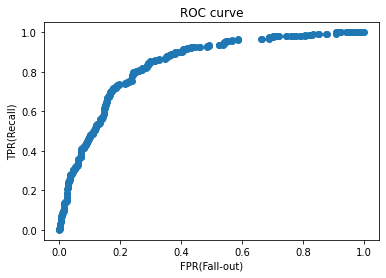

In [ ]:
# 선택한 Random Forest 의 ROC 커브

fpr, tpr, thresholds = roc_curve(y_val, rf1.predict_proba(X_val_selected)[:, 1])

plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')

왼쪽 상단쪽으로 예쁘게 휘어져있습니다!

In [ ]:
# 최적의 threshold

# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 218 , threshold: 0.4467140701488065


In [ ]:
from ipywidgets import interact, fixed

y_pred_proba = rf1.predict_proba(X_val_selected)[:,1]

def explore_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))

    
interact(explore_threshold, 
    y_true=fixed(y_val), 
    y_pred_proba=fixed(y_pred_proba), 
    threshold=(0, 1, 0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

<function __main__.explore_threshold>

임계값 조절을 하니 아주 미세하게나마 성능이 개선되었다 F1 0.659 -> 0.660. 그리고 이 문제에선 recall 값이 중요한데, 이것도 0.80 -> 0.85 로 올라서 긍정적으로 생각되네요!

# PDP(부분 의존도 플롯), SHAP

### 1피쳐 PDP

1개의 피쳐 tenure(이용 기간) 과 타겟 (고객 이탈여부) 에 어떤 영향을 끼치는지 보겠습니다.

(<Figure size 1080x684 with 3 Axes>,
 {'pdp_ax': {'_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa8b02235f8>,
   '_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa8a8daaa20>},
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa8a9bee080>})

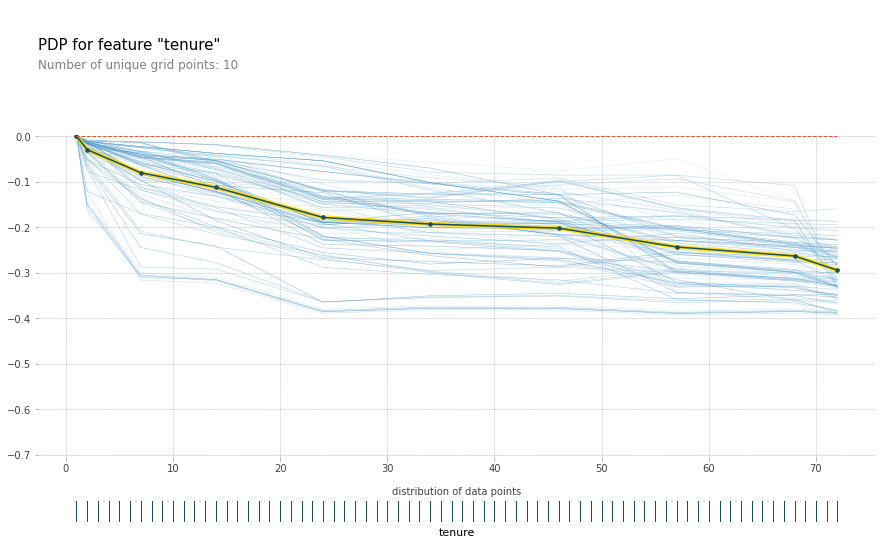

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'tenure'

isolated = pdp_isolate(
    model=rf1, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

타겟 = 고객의 이탈 여부 (1 = 이탈), tenure = 서비스 이용 기간 (월)

PDP(부분 의존도 플롯) 는 하나의 피쳐가 타겟에 어떤 영향을 끼치는지 보여줍니다. 위에 보이는 얇은 파란색 라인들은 ICE 커브라고 불리는데, 이것은 각각 하나의 샘플을 가지고 제가 지정한 피쳐 (tenure)의 값만 바꿔가며 타겟을 예측합니다. 그리고 그 예측한 값들을 가지고 각각 선을 그리는데 그것들의 평균이 중간에있는 노란색 라인입니다! 

위 그래프는 서비스 이용 기간이 고객의 이탈에 끼치는 영향을 보여주는 시각화입니다. x축은 서비스 이용기간(월)이고, y축은 타겟의 변화입니다(**주의* 확률아님**). 즉, 위 그림이 말하고 있는것은 '고객들의 서비스 이용 기간이 길수록 이탈률은 낮아진다' 입니다.

### 2 피쳐 PDP

2개의 피쳐 (이용기간, 전체 사용료) 가 타겟 예측에 어떤 영향을 끼치는지 보겠습니다.



In [ ]:
# 특성 2개 PDP
features_pdp = ['tenure', 'TotalCharges']

interaction = pdp_interact(
    model=rf1, 
    dataset=X_val_selected,
    model_features=X_val_selected.columns, 
    features=features_pdp
)

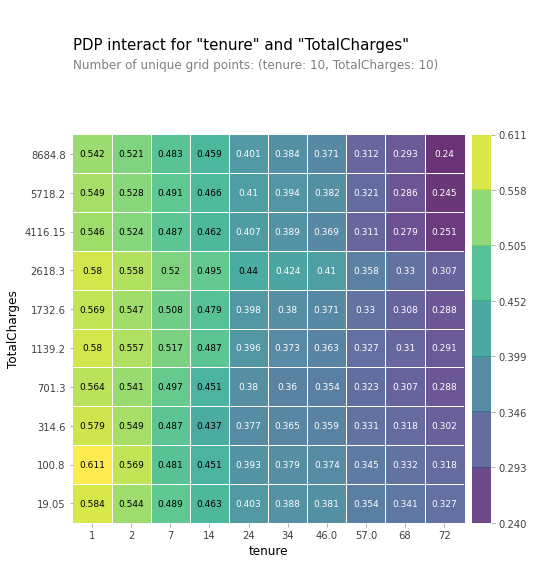

In [ ]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features_pdp);

위 그래프는 특성 2개(tenure: 서비스 이용 기간, TotalCharges: 총 이용 금액)과 타겟의 관계를 볼 수 있는 그래프입니다. 

y 축만 고려해 보시면, 이용기간이 같아도 총 이용 금액이 높을수록 이탈률은 낮게 예측합니다. 그리고 x 축만 보시면, 총 이용 금액이 같아도 이용 기간이 짧으면 이탈률을 높게 예측합니다.

그래프의 왼쪽 아래를 보시면, 이용기간이 1달이고 총 이용금액이 19.05인 고객의 이탈률은 0.58% 로 높게 예측했습니다. 그에반해, 오른쪽 상단에있는 이용기간이 72개월이고 총 이용금액이 8684.8인 고객의 이탈률은 0.24% 로 낮게 예측하고 있습니다. 즉, '이용기간이 짧을수록, 총 이용 금액이 낮을수록 이탈률은 높다'라고 말할 수 있겠습니다. 덧붙여 말하자면, 이용기간이 짧을수록 총 금액이 낮은것은 당연하겠죠?! ㅎㅎ

### SHAP

SHAP 은 샘플의 피쳐들이 타겟 예측에 각각 어떤 영향을 미쳤는지를 볼 수 있게 시각화 해줍니다.

In [ ]:
# 지금까지 과정(Pipeline, RandomizedSearchCV, permutation 등)들을 거친 rf1 모델은 SHAP 에서 
# 지원하지않는 모델타입이라고 자꾸 에러가떠서 에러 해결을위해 이것저것 해보다가 잘 안되서 다시 똑같이 만들고 학습시켰습니다.

###############################################################################
rfc = RandomForestClassifier(class_weight= 'balanced', max_depth= 13, 
                             max_features= 0.3, min_samples_leaf= 20, 
                             n_estimators=100,random_state=1,n_jobs=-1)
###############################################################################
rfc.fit(X_train_selected, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=13, max_features=0.3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:
import xgboost
import shap
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_val_selected.iloc[[10]])

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1], 
    features=X_val_selected.iloc[[10]], 
    # link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

SHAP 은 샘플의 피쳐들이 타겟 예측에 각각 어떤 영향을 미쳤는지를 볼 수 있게 시각화 해줍니다. 

제 모델은 이 고객(샘플)은 91%로 이탈할것이라는 예측을 했습니다. 

이탈 할것이라는 예측을 하게끔 만든 피쳐 top 5 :

1. tenure (서비스 이용 기간) = 1


    서비스 이용 기간이 짧은 고객들은 오래 이용한 고객들보다 이탈률이 훨씬 높습니다. 이 고객의 이용 기간이 고작 1달밖에 되지않았다는 점이 이 고객이 이탈할 것이라고 예측하는데에 크게 기여했습니다. 

2. Contract_Month-to-month (한달씩 계약) = 1 


    한 달씩 계약하는 사람들은 1년 혹은 2년씩 계약하는 사람들보다 이탈률이 굉장히 높은데요, 이 고객(샘플)은 한달씩 계약했다는 것이 이 고객이 이탈할 것이라고 예측하는데에 크게 기여했습니다. 

3. InternetService_Fiber optic (인터넷 공급방식) = 1


    인터넷 공급 방식중에 가장 높은 이탈률을 보이는것이 Fiber optic 입니다. 이 고객의 인터넷 공급방식도 Fiber optic 인데, 이것이 이 고객의 이탈 가능성을 높게 예측하는데에 기여했습니다.

4. PaymentMethod_Electronic check (지불 방식) =1


    이 고객의 지불방식은 Electronic check 인데, 이것은 다른 지불방식(송금, 우편)보다 훨씬 높은 이탈률을 보입니다. 이 점이 이 고객이 이탈할것이라고 예측하는데에 기여했습니다. 

5. TotalCharges (전체 이용료) = 69.65


    전체 이용료가 낮을수록 고객의 이탈률은 크게 나타나는데요, 500 이하인 고객들은 이탈률이 상당히 높습니다. 이 고객은 전체 이용료가 69.65 인것이 이 고객이 이탈할 것이라고 예측하는데에 기여했습니다.



91% 로 이탈 할 것이라고 예측을 했다면 9% 는 이탈하지 않을것이라고 예측을 했다는건데요, 여기에 기여한 피쳐들이 있겠지만, 엄청나게 큰 영향을 미치는 피쳐는 없는것으로 보입니다. 

# # 마치며.. (Confusion Matrix)

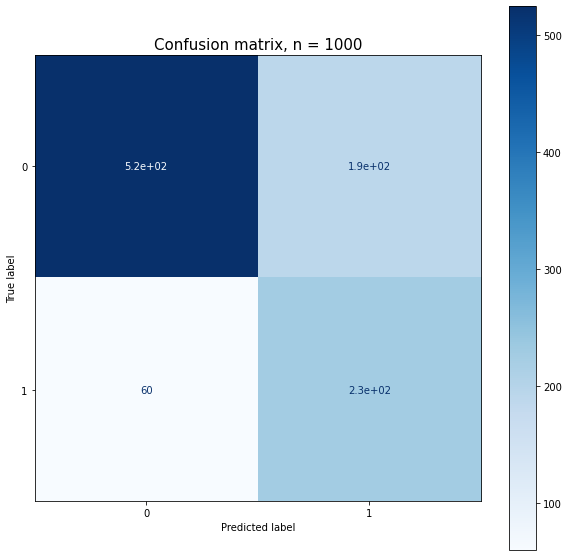

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
pcm = plot_confusion_matrix(rfc, X_val_selected, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()



시나리오를 다시 생각해보면, 제 시나리오의 목표는 이탈할 것으로 예상되는 고객들을 찾아내고, 그 분들이 다음계약을 진행할때 사은품을 증정함으로써 최대한 이탈을 막는 것이었습니다. 사은품을 모든 고객들에게 주면 좋겠지만 그럴 순 없으니 최대한 이탈고객을 잘 예측해야합니다.

이 문제에서 주목해야 할 점은 두가지입니다.

여러사람에게 사은품을 주는것에대한 부담 vs 고객이 이탈에 대한 리스크

이것은 Recall vs Precision 과 직결되는데요, Recall 값을 올리면 FP(이탈하지 않을 고객을 이탈한다고 예측) 이 증가할 수 있고, Precision 을 올리면 FN (이탈할 고객을 이탈하지 않는다고 예측) 이 증가할 수 있습니다.

사은품이 너무 비싸고 이탈을 막는데에 효율을 못낸다면 Precision 값이 중요합니다. 반대로, 사은품을 증정하여 고객이탈을 막는것이 정말 회사에 더 도움이 된다면 Recall 값을 중점적으로 봐야합니다. 왜냐하면, 실제론 이탈하지 않을 고객들에게 사은품을 주는것은 괜찮기 때문입니다! 제 시나리오에선 사인품을 증정하는 것이 고객이탈을 효과적으로 막는데 도움이 된다고 설정했기때문에 Recall 값이 중요합니다!



위 Confusion Matrix 를 보시면, 이 모델의 Precision 값은 약 0.54, Recall 값은 약 0.80 입니다. Recall 값이 비교적 높게나와서 제가 원한대로 모델이 만들어 진것 같습니다! 하지만 이러한 평가지표는 문제에따라 달라질 수 있으니 유동적으로 생각해야겠습니다!